In [52]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression, RidgeCV, Lasso, LassoCV, Ridge
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

import xgboost

In [3]:
test_labeled_df = pd.read_pickle('test_labeled_df.pkl')

In [4]:
test_labeled_df.head()

,is_customizable,num_favorers,processing_max,processing_min,quantity,views,when_made,who_made,price_usd,contains_silver,...,Charm Bracelets,Charm Necklaces,Chokers,Clip On Earrings,Crystal Necklaces,Cuff Bracelets,Dangle & Drop Earrings,Solitaire Rings,Stud Earrings,cluster_label
151842,0,8.0,3.0,1.0,4.0,514.0,standard,i_did,8.000,0,...,0,0,0,0,0,0,0,0,1,4
261700,0,11.0,1.0,1.0,1.0,34.0,vintage,someone_else,49.750,1,...,0,0,0,0,0,0,0,1,0,4
264540,0,8.0,1.0,1.0,1.0,49.0,vintage,someone_else,24.990,0,...,0,0,0,0,0,0,0,0,0,4
144297,1,5.0,2.0,1.0,20.0,25.0,standard,i_did,6.027,1,...,0,0,0,0,0,0,0,0,0,4
252974,1,46.0,10.0,5.0,2.0,359.0,made_to_order,i_did,67.320,1,...,0,0,0,0,0,0,0,0,0,4


In [24]:
test_labeled_d_2 = test_labeled_df.copy()

In [26]:
when_made = pd.get_dummies(test_labeled_d_2.when_made)

In [27]:
test_labeled_d_2 = pd.merge(test_labeled_d_2, when_made, left_index=True, right_index=True)

In [29]:
who_made = pd.get_dummies(test_labeled_d_2.who_made)

test_labeled_d_2 = pd.merge(test_labeled_d_2, who_made,left_index=True, right_index=True )

In [31]:
clusters = pd.get_dummies(test_labeled_d_2.cluster_label)

In [32]:
clusters = clusters.rename(columns={0:'cluster_0',1:'cluster_1',2:'cluster_2',
                                3:'cluster_3',4:'cluster_4'})

In [33]:
test_labeled_d_2 = pd.merge(test_labeled_d_2, clusters, left_index=True, right_index=True)

In [35]:
test_labeled_d_2 = test_labeled_d_2.drop(columns = ['when_made','who_made','cluster_label'])

In [96]:
test_labeled_d_2.head()

,is_customizable,num_favorers,processing_max,processing_min,quantity,views,price_usd,contains_silver,contains_gold,contains_glass,...,standard,vintage,collective,i_did,someone_else,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
151842,0,8.0,3.0,1.0,4.0,514.0,8.000,0,0,0,...,1,0,0,1,0,0,0,0,0,1
261700,0,11.0,1.0,1.0,1.0,34.0,49.750,1,0,0,...,0,1,0,0,1,0,0,0,0,1
264540,0,8.0,1.0,1.0,1.0,49.0,24.990,0,0,0,...,0,1,0,0,1,0,0,0,0,1
144297,1,5.0,2.0,1.0,20.0,25.0,6.027,1,0,0,...,1,0,0,1,0,0,0,0,0,1
252974,1,46.0,10.0,5.0,2.0,359.0,67.320,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [36]:
test_labeled_d_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62209 entries, 151842 to 15653
Data columns (total 44 columns):
is_customizable           62209 non-null int64
num_favorers              62209 non-null float64
processing_max            62209 non-null float64
processing_min            62209 non-null float64
quantity                  62209 non-null float64
views                     62209 non-null float64
price_usd                 62209 non-null float64
contains_silver           62209 non-null int64
contains_gold             62209 non-null int64
contains_glass            62209 non-null int64
contains_diamond          62209 non-null int64
contains_pearl            62209 non-null int64
contains_stone            62209 non-null int64
anniversary               62209 non-null uint8
birthday                  62209 non-null uint8
christmas                 62209 non-null uint8
engagement                62209 non-null uint8
mothers_day               62209 non-null uint8
valentines                62

In [97]:
test_label_reg_df = test_labeled_d_2.copy()

In [59]:
test_labeled_d_2.corr()['price_usd']

is_customizable           0.031275
num_favorers              0.021121
processing_max            0.136718
processing_min            0.139932
quantity                 -0.004998
views                     0.036750
price_usd                 1.000000
contains_silver          -0.066984
contains_gold             0.213431
contains_glass           -0.055043
contains_diamond          0.372801
contains_pearl           -0.009820
contains_stone            0.001212
anniversary               0.045483
birthday                 -0.002516
christmas                -0.001331
engagement                0.171556
mothers_day               0.016725
valentines               -0.000972
wedding                   0.082443
Bangles                  -0.002533
Beaded Bracelets         -0.039590
Bridal Sets               0.098649
Chandelier Earrings      -0.004424
Charm Bracelets          -0.021893
Charm Necklaces          -0.017108
Chokers                  -0.002477
Clip On Earrings         -0.011729
Crystal Necklaces   

In [40]:
test_labeled_d_2.columns

Index(['is_customizable', 'num_favorers', 'processing_max', 'processing_min',
       'quantity', 'views', 'price_usd', 'contains_silver', 'contains_gold',
       'contains_glass', 'contains_diamond', 'contains_pearl',
       'contains_stone', 'anniversary', 'birthday', 'christmas', 'engagement',
       'mothers_day', 'valentines', 'wedding', 'Bangles', 'Beaded Bracelets',
       'Bridal Sets', 'Chandelier Earrings', 'Charm Bracelets',
       'Charm Necklaces', 'Chokers', 'Clip On Earrings', 'Crystal Necklaces',
       'Cuff Bracelets', 'Dangle & Drop Earrings', 'Solitaire Rings',
       'Stud Earrings', 'made_to_order', 'standard', 'vintage', 'collective',
       'i_did', 'someone_else', 'cluster_0', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4'],
      dtype='object')

In [41]:
cols = ['is_customizable', 'num_favorers', 'processing_max', 'processing_min',
       'quantity', 'views', 'contains_silver', 'contains_gold',
       'contains_glass', 'contains_diamond', 'contains_pearl',
       'contains_stone', 'anniversary', 'birthday', 'christmas', 'engagement',
       'mothers_day', 'valentines', 'wedding', 'Bangles', 'Beaded Bracelets',
       'Bridal Sets', 'Chandelier Earrings', 'Charm Bracelets',
       'Charm Necklaces', 'Chokers', 'Clip On Earrings', 'Crystal Necklaces',
       'Cuff Bracelets', 'Dangle & Drop Earrings', 'Solitaire Rings',
       'Stud Earrings', 'made_to_order', 'standard', 'vintage', 'collective',
       'i_did', 'someone_else', 'cluster_0', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4']
X = test_labeled_d_2.loc[:,cols]
y = test_labeled_d_2.price_usd

In [92]:
# perform train/val split
X_train, X_val, y_train, y_val = \
    train_test_split(X, y, test_size=0.2, random_state=42)

# fit linear regression to training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

In [93]:
y_pred_val = lr_model.predict(X_val)

In [94]:
mean_absolute_error(y_val, y_pred_val)

118.64236935638847

In [95]:
print('Feature coefficient results: \n')

for feature, coef in zip(X.columns, lr_model.coef_):
    print(feature, ':', f'{coef:.2f}') 

Feature coefficient results: 

is_customizable : 1.42
num_favorers : -0.03
processing_max : 3.14
processing_min : 15.03
quantity : -0.06
views : 0.02
contains_silver : -24.98
contains_gold : 132.32
contains_glass : -32.92
contains_diamond : 697.67
contains_pearl : -7.66
contains_stone : 0.50
anniversary : 193.55
birthday : -12.02
christmas : -31.31
engagement : 859.59
mothers_day : 305.93
valentines : -33.08
wedding : 388.41
Bangles : -0.75
Beaded Bracelets : -31.05
Bridal Sets : 646.75
Chandelier Earrings : -17.46
Charm Bracelets : -35.11
Charm Necklaces : -46.15
Chokers : -14.13
Clip On Earrings : -73.89
Crystal Necklaces : -28.71
Cuff Bracelets : -14.10
Dangle & Drop Earrings : -38.61
Solitaire Rings : 26.64
Stud Earrings : -57.65
made_to_order : -22.93
standard : -15.91
vintage : 38.84
collective : 30.13
i_did : -7.39
someone_else : -22.74
cluster_0 : -3498.19
cluster_1 : 6994.01
cluster_2 : -410.07
cluster_3 : -1685.05
cluster_4 : -1400.70


In [129]:
mape(y_val,y_pred_val)

2.88990694610527

In [98]:
xgb = xgboost.XGBRegressor(max_depth=7,learning_rate=0.08,n_estimators=100 )

In [99]:
xgb.fit(X_train,y_train)

/anaconda3/envs/metis/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.08, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

In [117]:
cols1 = ['is_customizable', 'num_favorers', 'processing_max', 'processing_min',
       'quantity', 'views', 'contains_silver', 'contains_gold',
       'contains_glass', 'contains_diamond', 'contains_pearl',
       'contains_stone', 'anniversary', 'birthday', 'christmas', 'engagement',
       'mothers_day', 'valentines', 'wedding', 'Bangles', 'Beaded Bracelets',
       'Bridal Sets', 'Chandelier Earrings', 'Charm Bracelets',
       'Charm Necklaces', 'Chokers', 'Clip On Earrings', 'Crystal Necklaces',
       'Cuff Bracelets', 'Dangle & Drop Earrings', 'Solitaire Rings',
       'Stud Earrings', 'made_to_order', 'standard', 'vintage', 'collective',
       'i_did', 'someone_else']
X_val_noclust = X_val[cols1]

In [118]:
X_train_noclust = X_train[cols1]

In [100]:
xgb.score(X_val,y_val)

0.7105495379917384

In [119]:
xgb2 = xgboost.XGBRegressor(max_depth=7,learning_rate=0.08,n_estimators=100 )
xgb2.fit(X_train_noclust,y_train)

mape(y_val,xgb2.predict(X_val_noclust))

/anaconda3/envs/metis/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


2.4543733937207444

In [120]:
mean_absolute_error(y_val, xgb2.predict(X_val_noclust))

123.02417064663614

In [101]:
mean_absolute_error(y_val, xgb.predict(X_val))

95.1286264179552

In [106]:
def mape(actual,pred):
    error_val = abs(pred - actual)/actual
    return error_val.mean()

In [111]:
mape(y_val, xgb.predict(X_val))

1.9942634864501736

In [124]:
val_df = pd.concat([X_val,y_val], axis = 1)

In [150]:
y_pred_val_xgb = xgb.predict(X_val)

#### MAPE by Price Range

In [153]:
mape_20 = []
mape_100 = []
mape_1k = []
mape_10k = []
mape_high = []

for a,p in zip(y_val,y_pred_val_xgb):
    if a < 21.0:
        mape_20.append(mape(a,p))
    elif a>=21 and a <=100:
        mape_100.append(mape(a,p))
    elif a>100 and a<=1000:
        mape_1k.append(mape(a,p))
    elif a>1000 and a<=10000:
        mape_10k.append(mape(a,p))
    else:
        mape_high.append(mape(a,p))
        

In [161]:
print('price < 20  :  ',len(mape_20), ' | ', sum(mape_20)/len(mape_20))
print('price > 20 & < 100 . :  ', len(mape_100),  ' | ', sum(mape_100)/len(mape_100))
print('price > 100 & <1k . :  ', len(mape_1k),  ' | ', sum(mape_1k)/len(mape_1k))
print('price > 1k & <10k . :  ', len(mape_10k),  ' | ', sum(mape_10k)/len(mape_10k))
print('price > 10k . :  ', len(mape_high),  ' | ', sum(mape_high)/len(mape_high))

price < 20  :   5170  |  3.533885578862206
price > 20 & < 100 . :   5449  |  0.9731746356327342
price > 100 & <1k . :   1419  |  0.742903456549182
price > 1k & <10k . :   396  |  0.4593206765291191
price > 10k . :   8  |  0.4422841729746609


#### Absolute Error by price range

In [169]:
mae_20 = []
mae_100 = []
mae_1k = []
mae_10k = []
mae_high = []

for a,p in zip(y_val,y_pred_val_xgb):
    if a < 21.0:
        mae_20.append(abs(a-p))
    elif a>=21 and a <=100:
        mae_100.append(abs(a-p))
    elif a>100 and a<=1000:
        mae_1k.append(abs(a-p))
    elif a>1000 and a<=10000:
        mae_10k.append(abs(a-p))
    else:
        mae_high.append(abs(a-p))
        

In [170]:
print('price < 20  :  ',len(mae_20), ' | ', sum(mae_20)/len(mae_20))
print('price > 20 & < 100 . :  ', len(mae_100),  ' | ', sum(mae_100)/len(mae_100))
print('price > 100 & <1k . :  ', len(mae_1k),  ' | ', sum(mae_1k)/len(mae_1k))
print('price > 1k & <10k . :  ', len(mae_10k),  ' | ', sum(mae_10k)/len(mae_10k))
print('price > 10k . :  ', len(mae_high),  ' | ', sum(mae_high)/len(mae_high))

price < 20  :   5170  |  36.10132370566973
price > 20 & < 100 . :   5449  |  35.77217306727115
price > 100 & <1k . :   1419  |  222.04758141694987
price > 1k & <10k . :   396  |  1066.4506977832675
price > 10k . :   8  |  8077.9951171875


In [147]:
xgb.feature_importances_

array([1.85041793e-03, 8.35019071e-03, 4.66528628e-03, 3.51722259e-03,
       2.08687130e-03, 6.08277135e-03, 5.83309913e-03, 1.42233670e-02,
       1.03855319e-03, 4.32490520e-02, 8.10352992e-03, 3.37788346e-03,
       3.42828361e-03, 6.62548642e-04, 1.02384176e-04, 8.99870880e-03,
       6.18981570e-02, 4.85661265e-04, 3.52328946e-03, 9.95687558e-04,
       4.68670944e-04, 3.68543132e-03, 5.90661599e-04, 1.88728038e-04,
       6.77708769e-04, 2.35358195e-04, 2.98719795e-04, 3.03984503e-04,
       3.94734932e-04, 2.17636838e-03, 1.35760277e-03, 7.98728084e-04,
       8.40385072e-03, 4.40990226e-03, 1.86911516e-03, 4.01869696e-03,
       3.35908425e-03, 6.72399392e-03, 0.00000000e+00, 7.77565718e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00], dtype=float32)

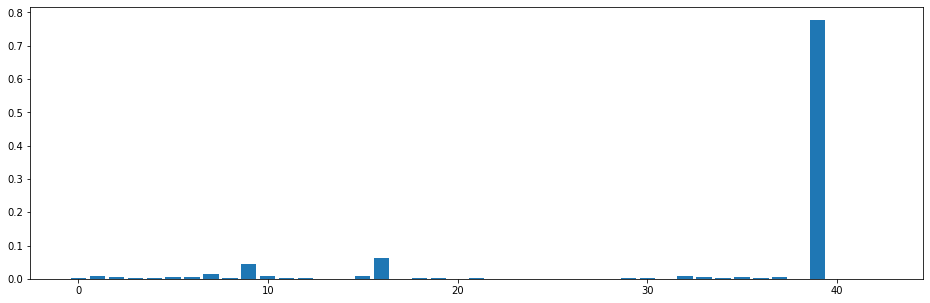

In [148]:
plt.figure(figsize=(16,5))
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_);

In [65]:
test_labeled_d_2.head()

,is_customizable,num_favorers,processing_max,processing_min,quantity,views,price_usd,contains_silver,contains_gold,contains_glass,...,standard,vintage,collective,i_did,someone_else,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
151842,0,8.0,3.0,1.0,4.0,514.0,8.000,0,0,0,...,1,0,0,1,0,0,0,0,0,1
261700,0,11.0,1.0,1.0,1.0,34.0,49.750,1,0,0,...,0,1,0,0,1,0,0,0,0,1
264540,0,8.0,1.0,1.0,1.0,49.0,24.990,0,0,0,...,0,1,0,0,1,0,0,0,0,1
144297,1,5.0,2.0,1.0,20.0,25.0,6.027,1,0,0,...,1,0,0,1,0,0,0,0,0,1
252974,1,46.0,10.0,5.0,2.0,359.0,67.320,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [66]:
test_labeled_df.head()

,is_customizable,num_favorers,processing_max,processing_min,quantity,views,when_made,who_made,price_usd,contains_silver,...,Charm Bracelets,Charm Necklaces,Chokers,Clip On Earrings,Crystal Necklaces,Cuff Bracelets,Dangle & Drop Earrings,Solitaire Rings,Stud Earrings,cluster_label
151842,0,8.0,3.0,1.0,4.0,514.0,standard,i_did,8.000,0,...,0,0,0,0,0,0,0,0,1,4
261700,0,11.0,1.0,1.0,1.0,34.0,vintage,someone_else,49.750,1,...,0,0,0,0,0,0,0,1,0,4
264540,0,8.0,1.0,1.0,1.0,49.0,vintage,someone_else,24.990,0,...,0,0,0,0,0,0,0,0,0,4
144297,1,5.0,2.0,1.0,20.0,25.0,standard,i_did,6.027,1,...,0,0,0,0,0,0,0,0,0,4
252974,1,46.0,10.0,5.0,2.0,359.0,made_to_order,i_did,67.320,1,...,0,0,0,0,0,0,0,0,0,4


In [68]:
test_labeled_df.groupby('cluster_label').mean()

,is_customizable,num_favorers,processing_max,processing_min,quantity,views,price_usd,contains_silver,contains_gold,contains_glass,...,Chandelier Earrings,Charm Bracelets,Charm Necklaces,Chokers,Clip On Earrings,Crystal Necklaces,Cuff Bracelets,Dangle & Drop Earrings,Solitaire Rings,Stud Earrings
cluster_label,,,,,,,,,,,,,,,,,,,,,
0,0.833333,4029.833333,6.333333,4.333333,42.000000,126330.500000,247.720000,0.500000,0.333333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.457547,45.613208,5.033019,2.896226,2.070755,501.396226,8933.796840,0.009434,0.632075,0.000000,...,0.000000,0.000000,0.004717,0.009434,0.000000,0.004717,0.014151,0.018868,0.014151,0.009434
2,0.666667,19.333333,1.666667,1.000000,15317.000000,88.333333,99.000000,0.333333,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000
3,0.528302,1985.424528,7.000000,4.150943,79.075472,20682.641509,275.064647,0.386792,0.330189,0.066038,...,0.000000,0.000000,0.028302,0.000000,0.009434,0.000000,0.000000,0.028302,0.009434,0.018868
4,0.317508,26.726803,3.707282,1.951149,12.036893,181.654391,114.882406,0.302414,0.161937,0.113927,...,0.003248,0.022187,0.017501,0.006771,0.006270,0.006900,0.018745,0.094034,0.010051,0.024030


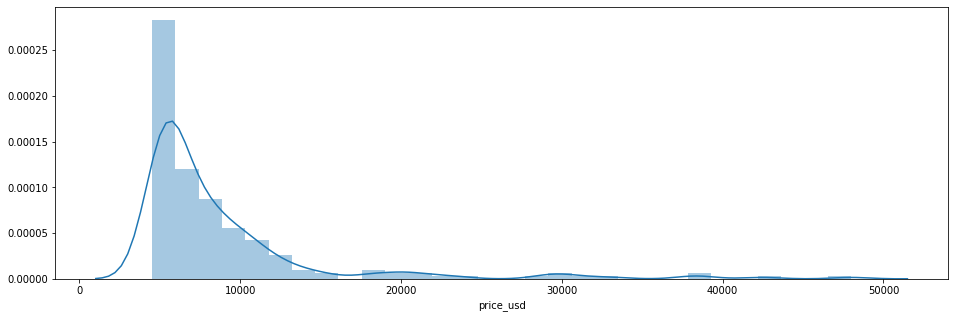

In [72]:
plt.figure(figsize=(16,5))
sns.distplot(test_labeled_df.price_usd[test_labeled_df.cluster_label==1]);

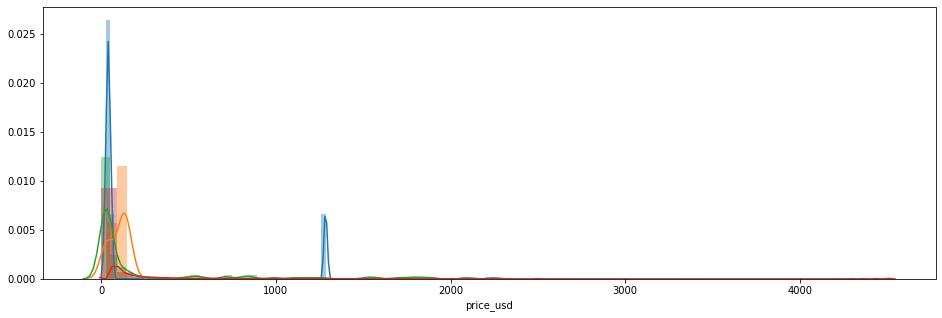

In [79]:
plt.figure(figsize=(16,5))
sns.distplot(test_labeled_df.price_usd[test_labeled_df.cluster_label==0]);
# sns.distplot(test_labeled_df.price_usd[test_labeled_df.cluster_label==1]);
sns.distplot(test_labeled_df.price_usd[test_labeled_df.cluster_label==2]);
sns.distplot(test_labeled_df.price_usd[test_labeled_df.cluster_label==3]);
sns.distplot(test_labeled_df.price_usd[test_labeled_df.cluster_label==4]);

In [86]:
test_labeled_df.groupby('cluster_label').mean()

,is_customizable,num_favorers,processing_max,processing_min,quantity,views,price_usd,contains_silver,contains_gold,contains_glass,...,Chandelier Earrings,Charm Bracelets,Charm Necklaces,Chokers,Clip On Earrings,Crystal Necklaces,Cuff Bracelets,Dangle & Drop Earrings,Solitaire Rings,Stud Earrings
cluster_label,,,,,,,,,,,,,,,,,,,,,
0,0.833333,4029.833333,6.333333,4.333333,42.000000,126330.500000,247.720000,0.500000,0.333333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.457547,45.613208,5.033019,2.896226,2.070755,501.396226,8933.796840,0.009434,0.632075,0.000000,...,0.000000,0.000000,0.004717,0.009434,0.000000,0.004717,0.014151,0.018868,0.014151,0.009434
2,0.666667,19.333333,1.666667,1.000000,15317.000000,88.333333,99.000000,0.333333,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000
3,0.528302,1985.424528,7.000000,4.150943,79.075472,20682.641509,275.064647,0.386792,0.330189,0.066038,...,0.000000,0.000000,0.028302,0.000000,0.009434,0.000000,0.000000,0.028302,0.009434,0.018868
4,0.317508,26.726803,3.707282,1.951149,12.036893,181.654391,114.882406,0.302414,0.161937,0.113927,...,0.003248,0.022187,0.017501,0.006771,0.006270,0.006900,0.018745,0.094034,0.010051,0.024030


In [87]:
test_labeled_df.cluster_label.value_counts()

4    61882
1      212
3      106
0        6
2        3
Name: cluster_label, dtype: int64

In [88]:
test_labeled_df.head()

,is_customizable,num_favorers,processing_max,processing_min,quantity,views,when_made,who_made,price_usd,contains_silver,...,Charm Bracelets,Charm Necklaces,Chokers,Clip On Earrings,Crystal Necklaces,Cuff Bracelets,Dangle & Drop Earrings,Solitaire Rings,Stud Earrings,cluster_label
151842,0,8.0,3.0,1.0,4.0,514.0,standard,i_did,8.000,0,...,0,0,0,0,0,0,0,0,1,4
261700,0,11.0,1.0,1.0,1.0,34.0,vintage,someone_else,49.750,1,...,0,0,0,0,0,0,0,1,0,4
264540,0,8.0,1.0,1.0,1.0,49.0,vintage,someone_else,24.990,0,...,0,0,0,0,0,0,0,0,0,4
144297,1,5.0,2.0,1.0,20.0,25.0,standard,i_did,6.027,1,...,0,0,0,0,0,0,0,0,0,4
252974,1,46.0,10.0,5.0,2.0,359.0,made_to_order,i_did,67.320,1,...,0,0,0,0,0,0,0,0,0,4


In [172]:
test_labeled_df.sample(n=1)

,is_customizable,num_favorers,processing_max,processing_min,quantity,views,when_made,who_made,price_usd,contains_silver,...,Charm Bracelets,Charm Necklaces,Chokers,Clip On Earrings,Crystal Necklaces,Cuff Bracelets,Dangle & Drop Earrings,Solitaire Rings,Stud Earrings,cluster_label
91706,0,10.0,2.0,1.0,1.0,77.0,vintage,someone_else,29.99,0,...,0,0,0,0,0,1,0,0,0,4


In [ ]:
plt.cm.rainbow()